# Densenet

densenet是由稠密块(dense block)和过渡块(transition block)构成的

## dense block

dense block可以看作residual的变体，把加法改成连结的形式。bn+relu+conv.

DenseNet的卷积块使用ResNet改进版本的BN->Relu->Conv。每个卷积的输出通道数被称之为growth_rate，这是因为假设输出为in_channels，而且有layers层，那么输出的通道数就是in_channels+growth_rate*layers

In [5]:
from mxnet import nd
from mxnet import gluon
from mxnet.gluon import nn

def conv_block(channels):
    out = nn.Sequential()
    out.add(
        nn.BatchNorm(),
        nn.Activation(activation='relu'),
        nn.Conv2D(channels,kernel_size=1),
        nn.BatchNorm(),
        nn.Activation(activation='relu'),
        nn.Conv2D(channels,kernel_size=3,padding=1)
    )
    return out

class DenseBlock(nn.Block):
    def __init__(self,layers,growth_rate,**kwargs):
        super(DenseBlock,self).__init__(**kwargs)
        self.net = nn.Sequential()
        for i in range(layers):
            self.net.add(
                conv_block(growth_rate)
            )
    def forward(self,x):
        for layer in self.net:
            out = layer(x)
            x = nd.concat(x,out,dim=1)
        return out
    

In [6]:
dblk = DenseBlock(growth_rate=10,layers=2)
dblk.initialize()
x = nd.random.uniform(shape=(4,3,112,112))
dblk(x).shape

(4L, 10L, 112L, 112L)

## 过渡层 transition block

用来将通道数减半，并把输入的长宽减半


In [7]:
def transition_block(channels):
    out = nn.Sequential()
    out.add(
        nn.BatchNorm(),
        nn.Activation(activation='relu'),
        nn.Conv2D(channels,kernel_size=1),
        nn.AvgPool2D(pool_size=2,strides=2)
    )
    return out

In [8]:
tsbk = transition_block(8)
tsbk.initialize()
tsbk(x).shape

(4L, 8L, 56L, 56L)

## densenet的结构



In [9]:
class DenseNet(nn.Block):
    def __init__(self,channels1,layers,growth_rate,num_outputs,verbose=False,**kwargs):
        # channels1是第一个conv层的输出数，layers是连续几个稠密块后加一个过渡块，growth_rate是每个稠密块的输出数
        super(DenseNet,self).__init__(**kwargs)
        self.verbose = verbose
        b1 = nn.Sequential()
        b1.add(
            nn.BatchNorm(),
            nn.Activation('relu'),
            nn.Conv2D(channels1,kernel_size=7,padding=3,strides=2),
            nn.MaxPool2D(pool_size=3,strides=2,padding=1)
        )
        b2 = nn.Sequential()
        for i,layer in enumerate(layers):
            b2.add(DenseBlock(layer,growth_rate))
            #如果不是最后一层，就加过渡层
            if i != len(layers)-1:
                b2.add(transition_block(layer//2))
        b3 = nn.Sequential()
        b3.add(
            nn.BatchNorm(),
            nn.Activation('relu'),
            nn.AvgPool2D(pool_size=3),
            nn.Flatten(),
            nn.Dense(num_outputs)
        )
        self.net = nn.Sequential()
        self.net.add(b1,b2,b3)
    
    def forward(self,x):
        out = x
        for i,layer in enumerate(self.net):
            out = layer(out)
            if self.verbose:
                print("layer %d output shape is %s"%(i+1,out.shape))
        return out
    

In [10]:
net = DenseNet(4,[6,12,24,16],32,10,True)
net.initialize()
x = nd.random.normal(shape=(12,3,112,112))
net(x).shape

layer 1 output shape is (12L, 4L, 28L, 28L)
layer 2 output shape is (12L, 32L, 3L, 3L)
layer 3 output shape is (12L, 10L)


(12L, 10L)

('Start training on ', gpu(0))
Epoch 0. Loss: 1.621, Train acc 0.47, Test acc 0.74, Time 105.3 sec
Epoch 1. Loss: 0.734, Train acc 0.77, Test acc 0.77, Time 98.9 sec
Epoch 2. Loss: 0.550, Train acc 0.81, Test acc 0.83, Time 101.4 sec
Epoch 3. Loss: 0.473, Train acc 0.84, Test acc 0.82, Time 109.8 sec
Epoch 4. Loss: 0.437, Train acc 0.85, Test acc 0.85, Time 94.7 sec


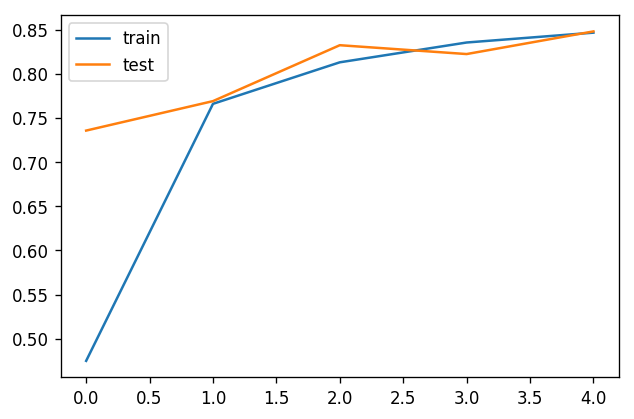

In [11]:
import sys
sys.path.append('..')
import utils
from mxnet import gluon
from mxnet import init

train_data, test_data = utils.load_data_fashion_mnist(
    batch_size=128, resize=112)

ctx = utils.try_gpu()
net = DenseNet(64,[6,12,24,16],32,10)
net.initialize(ctx=ctx, init=init.Xavier())

loss = gluon.loss.SoftmaxCrossEntropyLoss()
trainer = gluon.Trainer(net.collect_params(),
                        'sgd', {'learning_rate': 0.01})
utils.train(train_data, test_data, net, loss,
            trainer, ctx, num_epochs=5,show=True)